In [3]:
from commonfunctions import *
import cv2  as cv
import imutils
import numpy as np


In [221]:
def calculate_contour_distance(contour1, contour2): # 
    x1, y1, w1, h1 = cv.boundingRect(contour1)
    c_x1 = x1 + w1/2
    c_y1 = y1 + h1/2

    x2, y2, w2, h2 = cv.boundingRect(contour2)
    c_x2 = x2 + w2/2
    c_y2 = y2 + h2/2

    return (abs(c_x1 - c_x2) , abs(c_y1 - c_y2))

def merge_contours(contour1, contour2):
    return np.concatenate((contour1, contour2), axis=0)

def agglomerative_cluster(contours, threshold_distance=110.0):
    current_contours = contours
    while len(current_contours) > 1:
        min_distance = None
        min_coordinate = None
        
        for x in range(len(current_contours)-1):
            for y in range(x+1, len(current_contours)):
                distancex,distancey = calculate_contour_distance(current_contours[x], current_contours[y])
                if min_distance is None and distancey <= 25:
                    min_distance = distancex
                    min_coordinate = (x, y)
                elif  min_distance != None and distancex < min_distance and distancey <= 25:
                    min_distance = distancex
                    min_coordinate = (x, y)
        
        if  min_distance != None and min_distance < threshold_distance :
            index1, index2 = min_coordinate
            current_contours[index1] = merge_contours(current_contours[index1], current_contours[index2])
            del current_contours[index2]
        else:
            break

    return current_contours


In [222]:
def LPD(img):
    
    #? Step 1: Edge Detection
    #img = cv.resize(img, (1200,1200), interpolation=cv.INTER_CUBIC)

   
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = gray[gray.shape[0]*2//5:gray.shape[0],:]
    #show_images([gray])
    gray = cv.GaussianBlur(gray, (3,3),0)
    img = img[img.shape[0]*2//5:img.shape[0],:]
    
    # The Black Hat operation is the difference between the closing and input image 
    
    rectKern = cv.getStructuringElement(cv.MORPH_RECT, (7,5))
    blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, rectKern)
    #show_images([blackhat])


    img_thresh = blackhat
    img_thresh[ img_thresh < 50 ] = 0
    img_thresh[ img_thresh >= 50 ] = 255
    #show_images([img_thresh])
    
    sobel_x = cv.Sobel(img_thresh, cv.CV_64F, 1, 0, ksize=3)  # Gradient in x-direction
    sobel_x = np.absolute(sobel_x)
    maxVal = np.max(sobel_x)
    sobel_x = 255 * ((sobel_x) / (maxVal))
    sobel_x = sobel_x.astype("uint8")
    #show_images([sobel_x])

    
    closeKern = cv.getStructuringElement(cv.MORPH_RECT, (7,7))
    closed_image = cv.morphologyEx(sobel_x, cv.MORPH_CLOSE, closeKern)
    #show_images([closed_image])
    
    
    temp1= cv.erode(closed_image, None, iterations = 2)
    temp1 = cv.dilate(temp1, None, iterations = 3)
    #show_images([temp1])
    tempx= cv.erode(temp1, None, iterations = 2)
    tempx = cv.dilate(tempx, None, iterations = 3)
    #show_images([tempx])
    
    tempx[ tempx < 140 ] = 0
    tempx[ tempx >= 140 ] = 255
    #show_images([tempx],["Binraization new"])
    
    
    temp2 = cv.erode(tempx, None, iterations = 2)
    temp2 = cv.dilate(temp2, None, iterations = 9)
    
    #show_images([temp2])
    
#     temp2 = cv.erode(temp2, None, iterations = 2)
#     temp2 = cv.dilate(temp2, (5,9), iterations = 6)
    kkk = cv.getStructuringElement(cv.MORPH_RECT, (7,1))
    temp2 = cv.dilate(temp2, kkk, iterations = 3)
        
#     show_images([temp2],["hello world !!!!!!"])
    
    
    img1_thresh = temp2

   #show_images([img1_thresh])

    
    contours, hierarchy = cv.findContours(img1_thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #get the contours

    merged_contours = []
    copyContours = list(contours)
    merged_contours = agglomerative_cluster(copyContours) # merge contours which is close together
    
    cnts = sorted(merged_contours, key=cv.contourArea, reverse=True)
    
    
    img_cont = img.copy()
    cv.drawContours(img_cont,cnts,-1, (0, 255, 0), 2)
    
    for cnt in cnts:

        area = cv.contourArea(cnt)
        x1, y1, w1, h1 = cv.boundingRect(cnt)
        c_x1 = x1 + w1/2
        c_y1 = y1 + h1/2
        
        text = f"x: {c_x1}, y: {c_y1}"
        cv.putText(img_cont, text, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        
        if 500 < area < 15000: # filter on the area of the contours 
        
        
            peri = cv.arcLength(cnt, True)
            approx = cv.approxPolyDP(cnt, 0.02 * peri, True)
            x, y, w, h = cv.boundingRect(approx)
            ar = w / float(h)

            if (ar>=1.5 and ar<=6):
                #cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cropped_image = img[y:y + h, x:x + w]
                #show_images([cropped_image])
                return cropped_image

In [235]:
def DetectChars(img):    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    rectKern = cv.getStructuringElement(cv.MORPH_RECT, (9,9))
    blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, rectKern)
    
    binary_image = blackhat.copy()
    binary_image[ binary_image < 50 ] = 0
    binary_image[ binary_image >= 50 ] = 255
    
    erode = cv.erode(binary_image,(3,3),iterations=2)
    dilate = cv.dilate(erode,(3,3),iterations=1)
    erode = cv.erode(dilate,(3,3),iterations=2)
     
    
        
    canny  = cv.Canny(binary_image, 50, 120)
    
    contours, hierarchy  = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) #get the contours

    
#     cnts = sorted(contours, key=cv.contourArea, reverse=True)
#     filtered_contours=[]
#     avg_area = cv.contourArea(cnts[len(cnts)//2])
    
    
#     for c in contours:
#         area = cv.contourArea(c)
#         if (area>= avg_area+1 or area<=avg_area-1):
#             continue
#         filtered_contours.append(c)
    
#     mid_line = gray.shape[0]//2
        
    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
    
#     cv.drawContours(img,contours,-1, (0, 255, 0), 1)
    show_images([img,gray,blackhat,binary_image,dilate,erode])
    
    
    

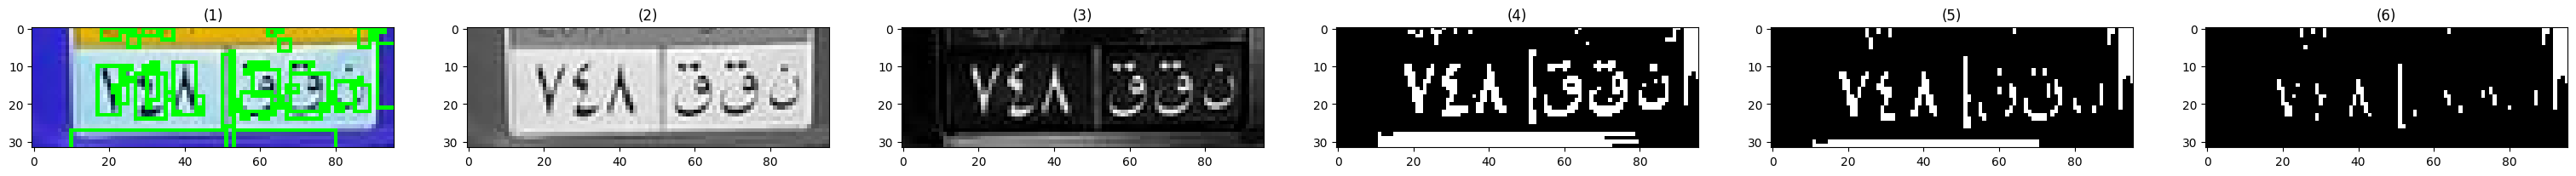

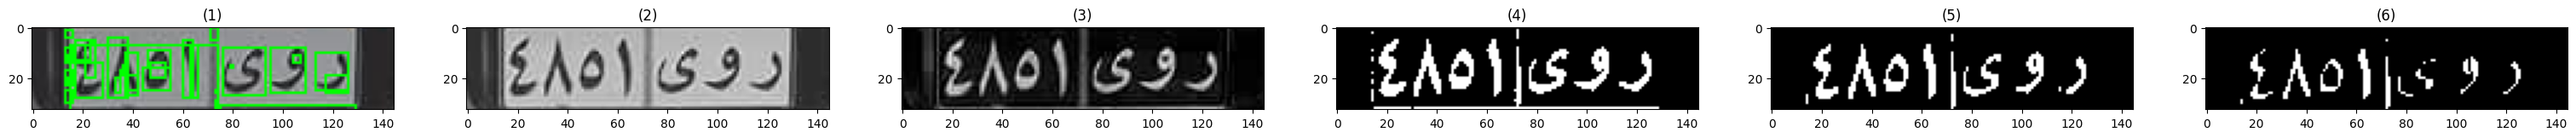

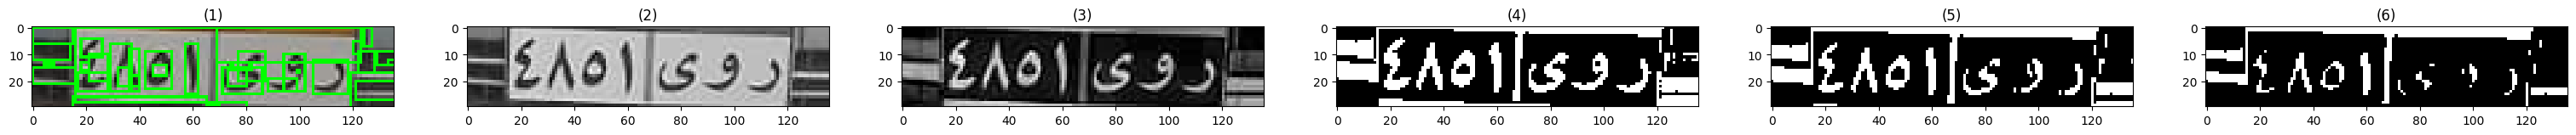

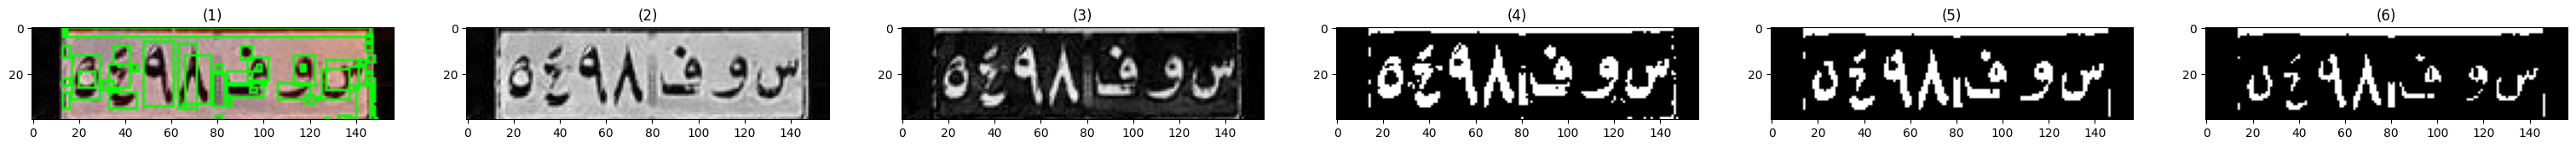

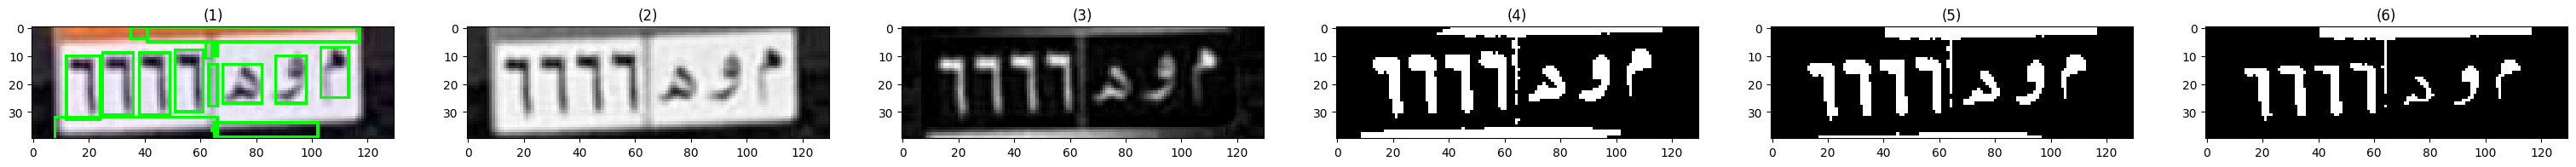

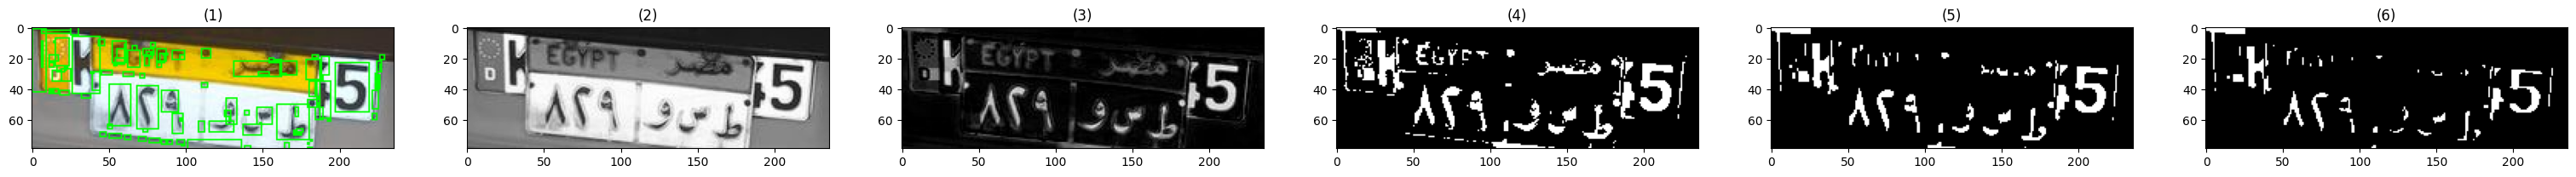

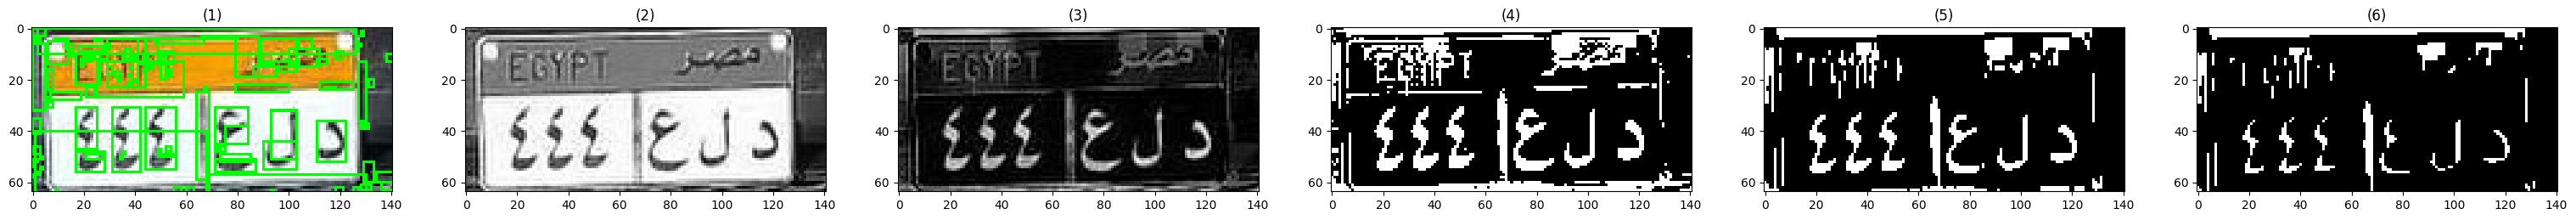

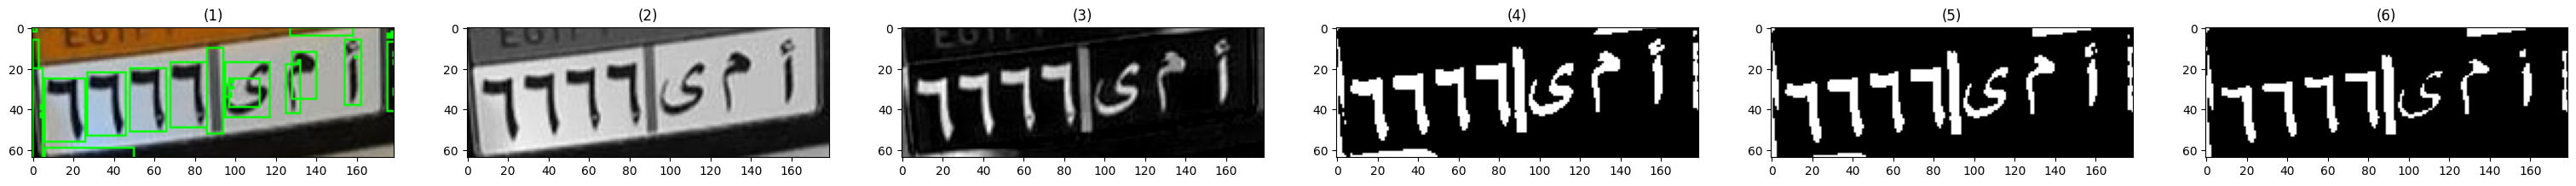

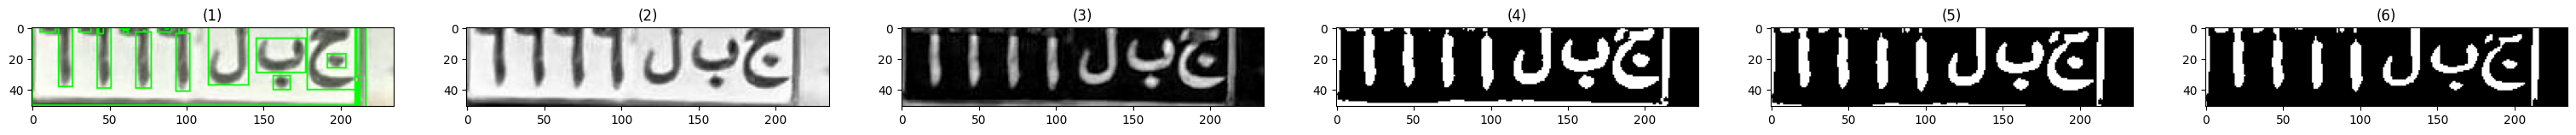

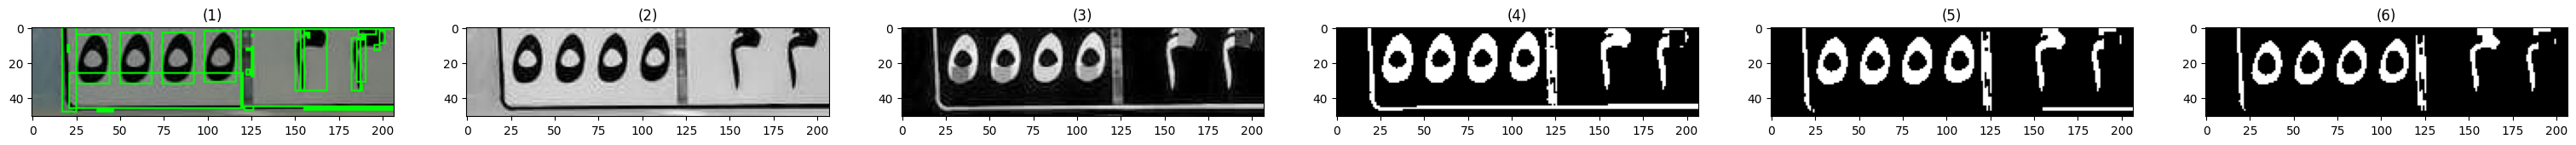

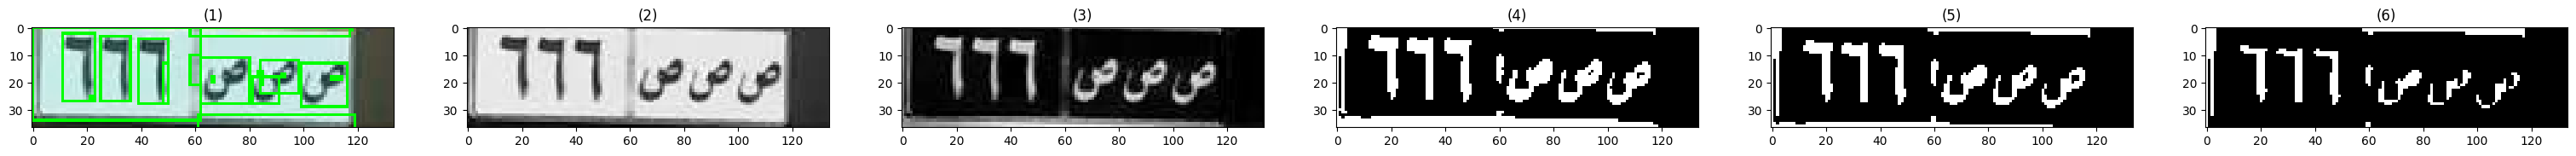

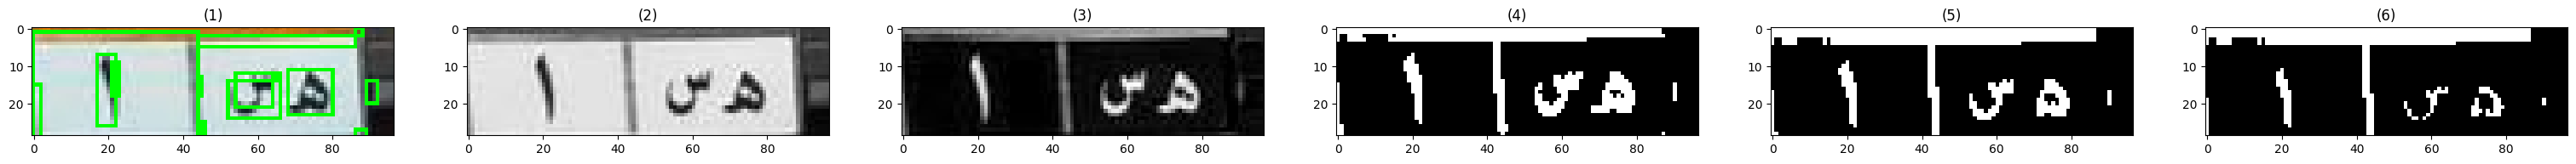

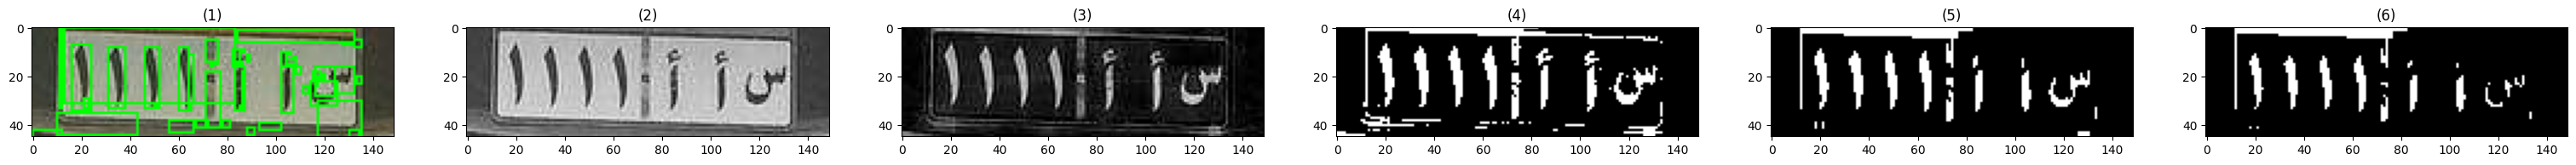

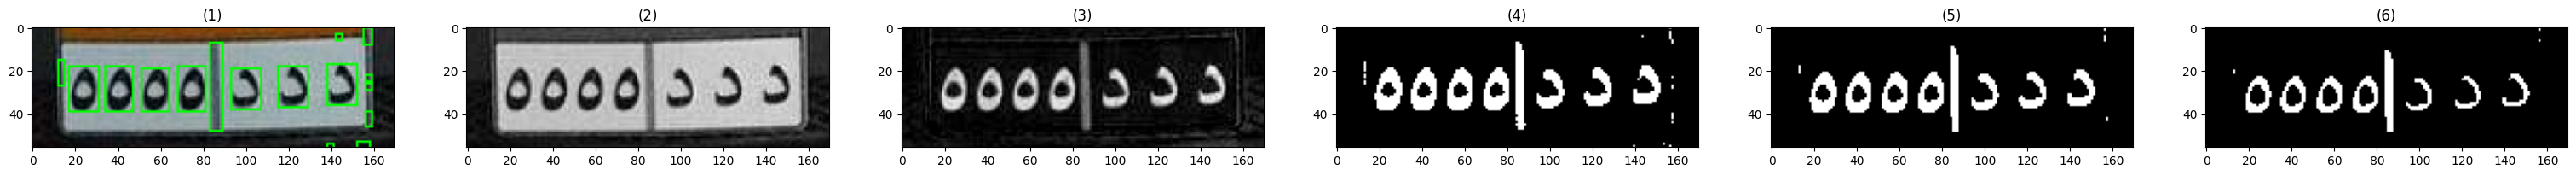

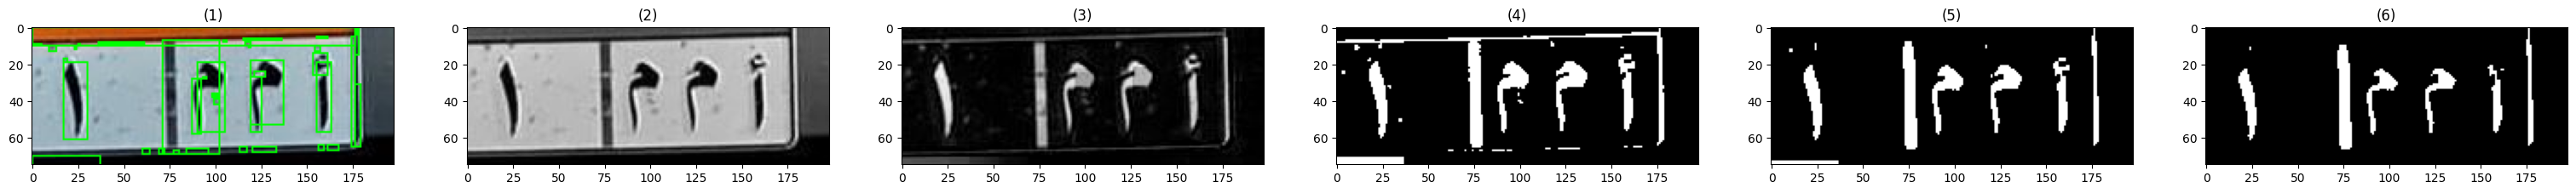

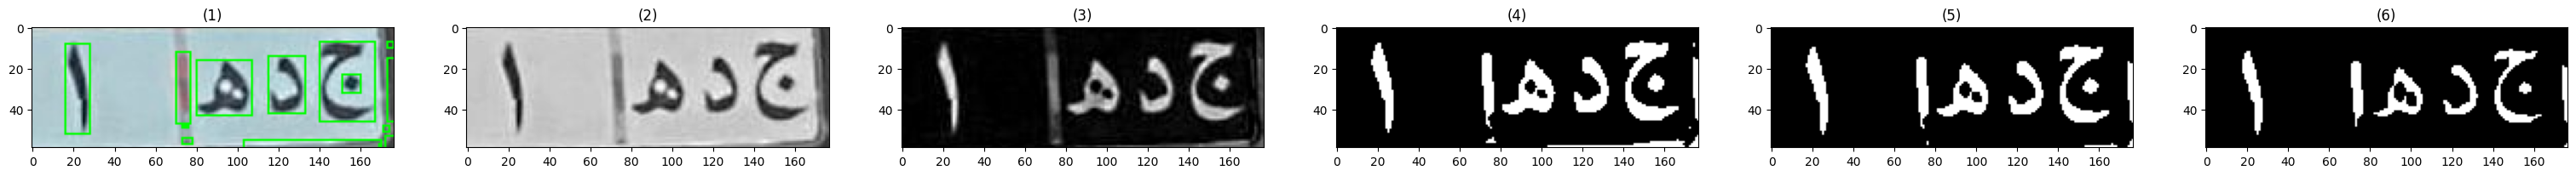

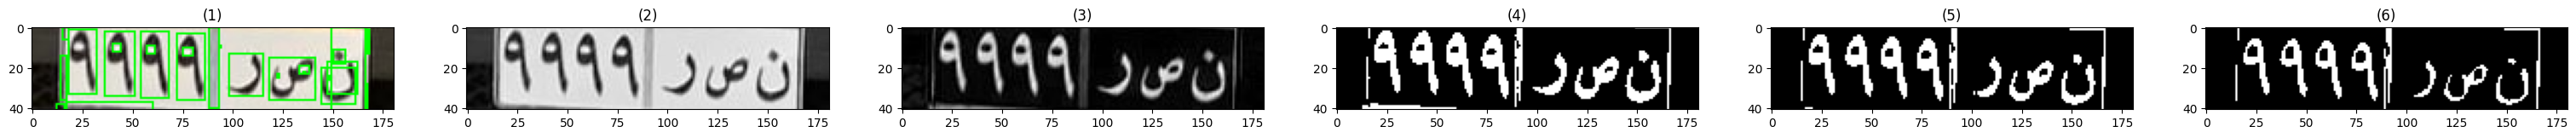

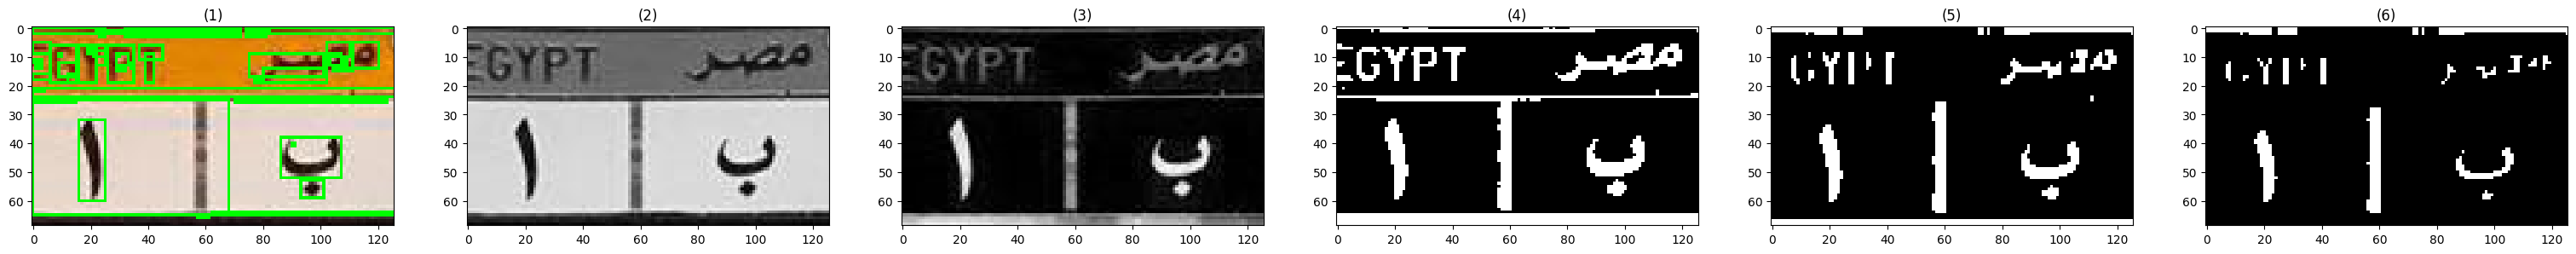

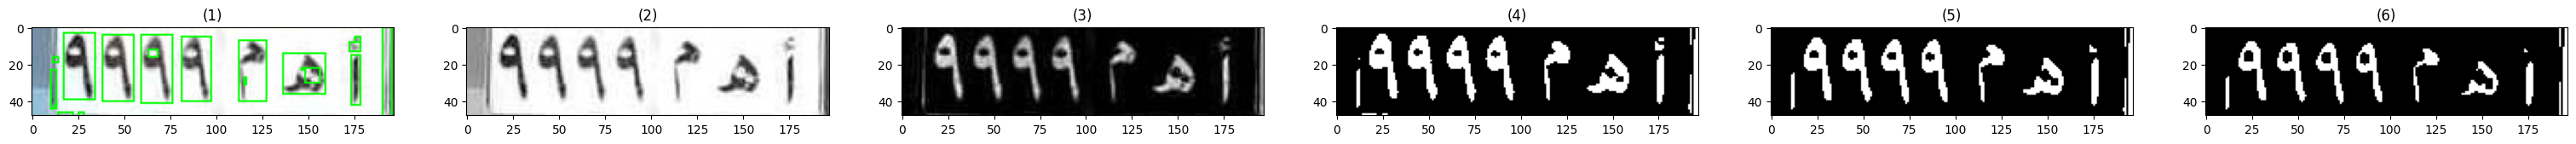

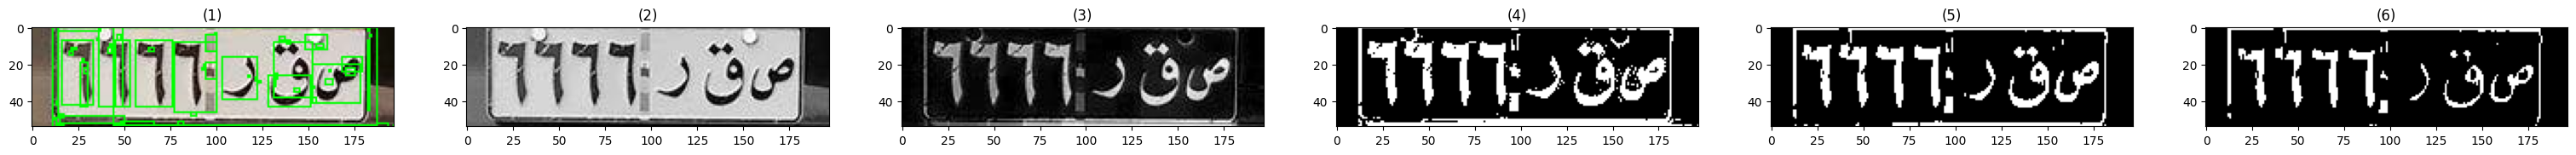

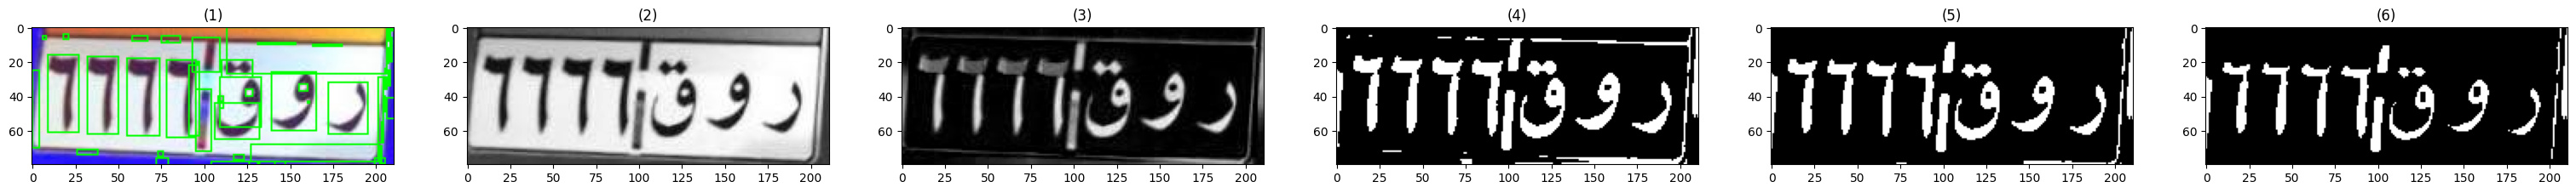

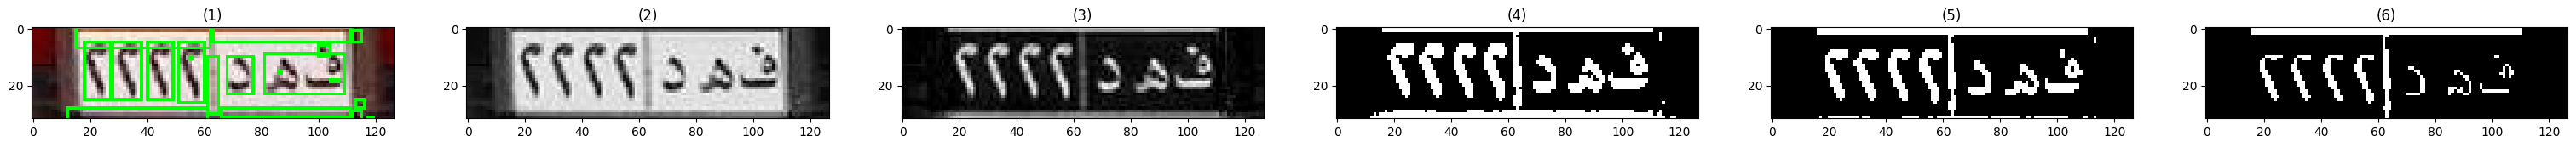

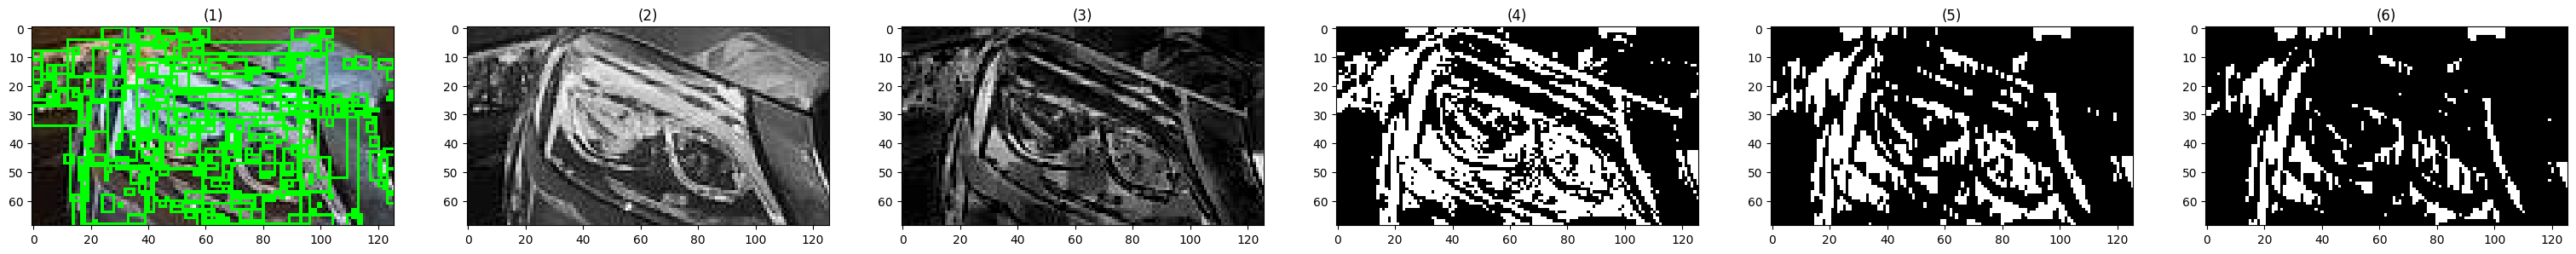

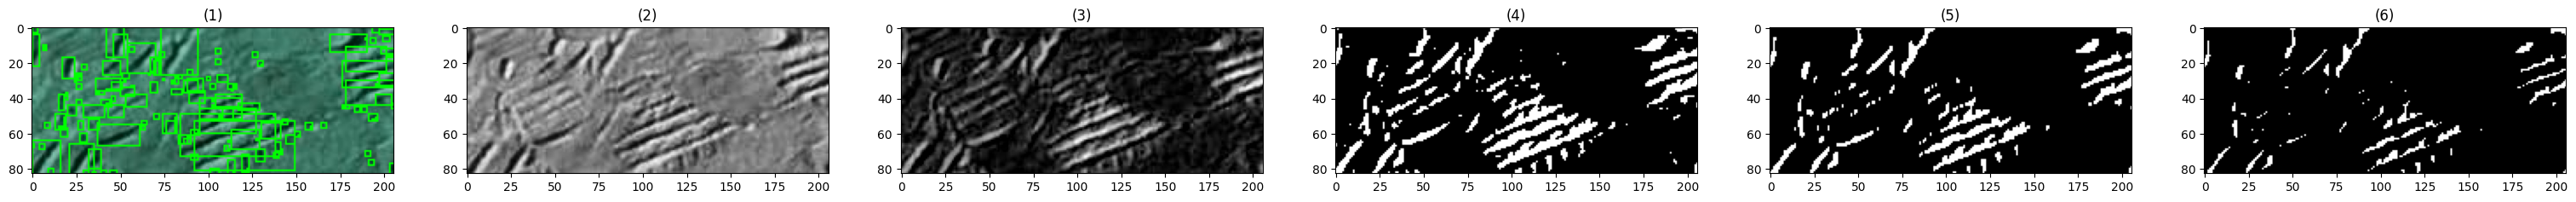

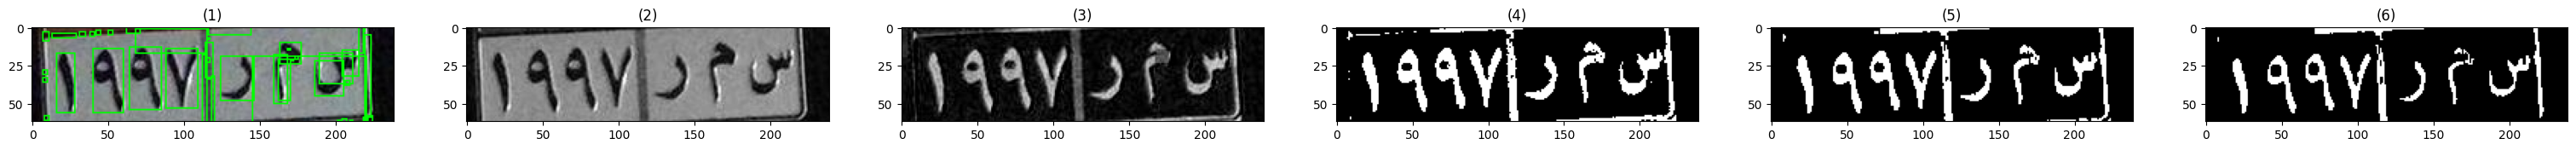

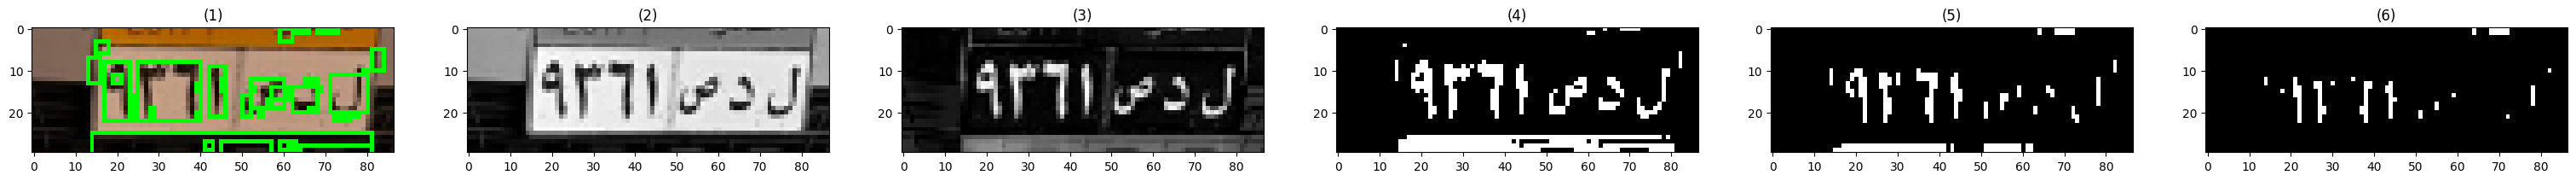

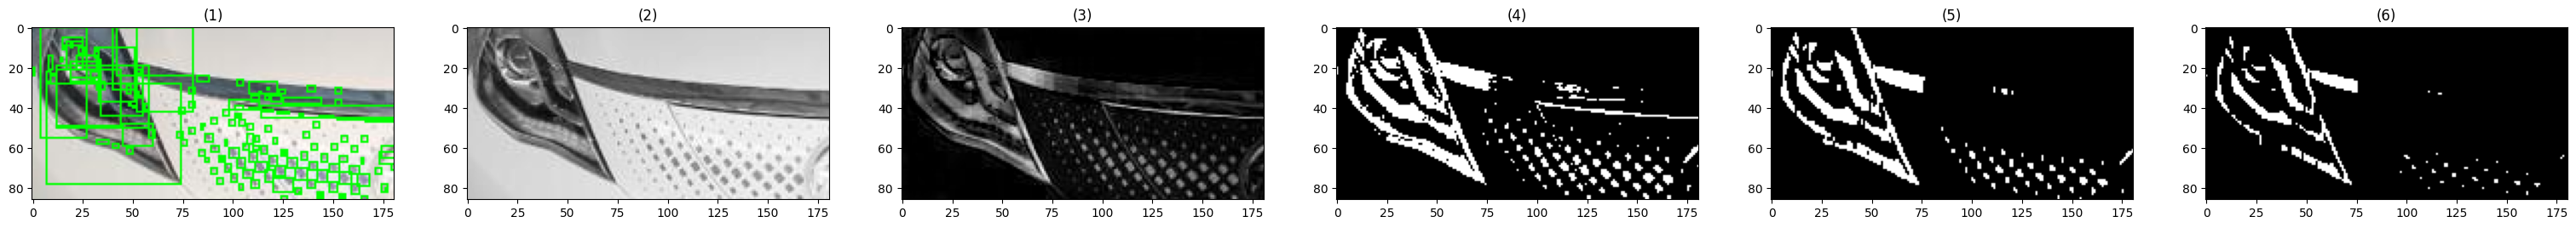

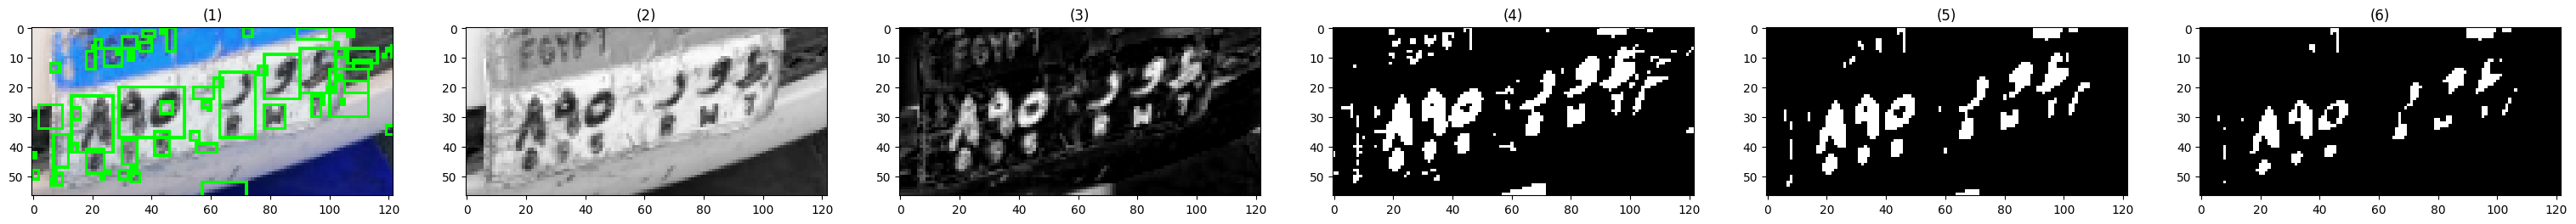

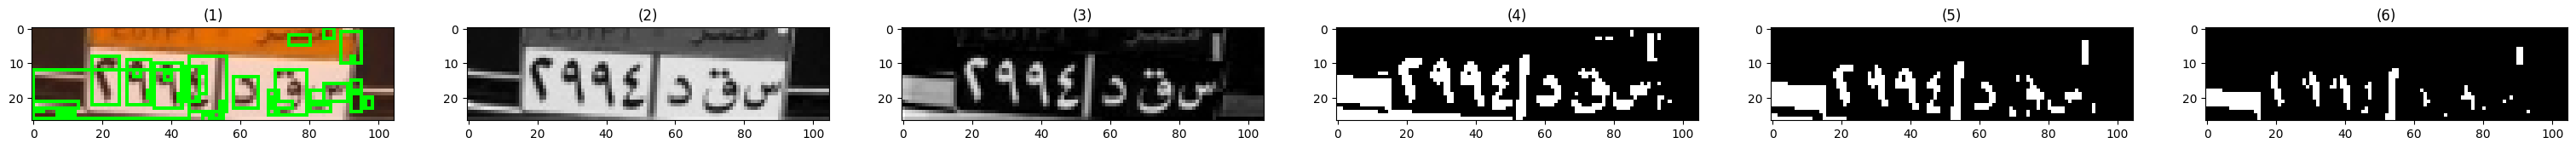

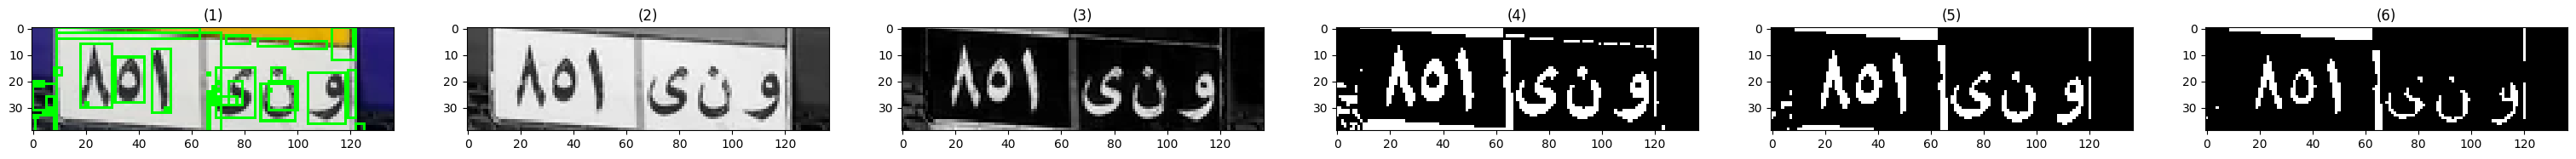

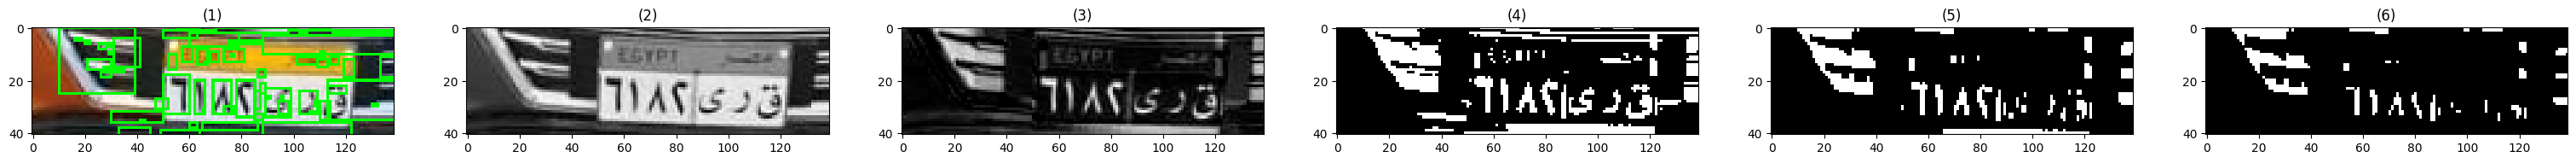

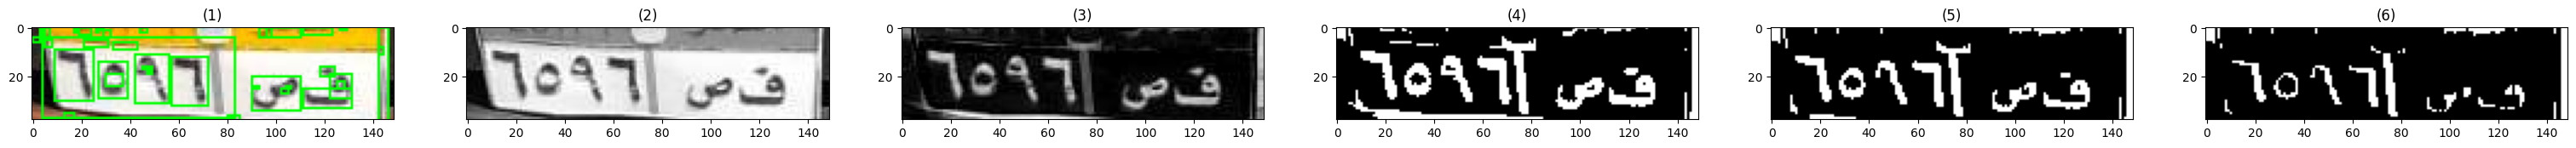

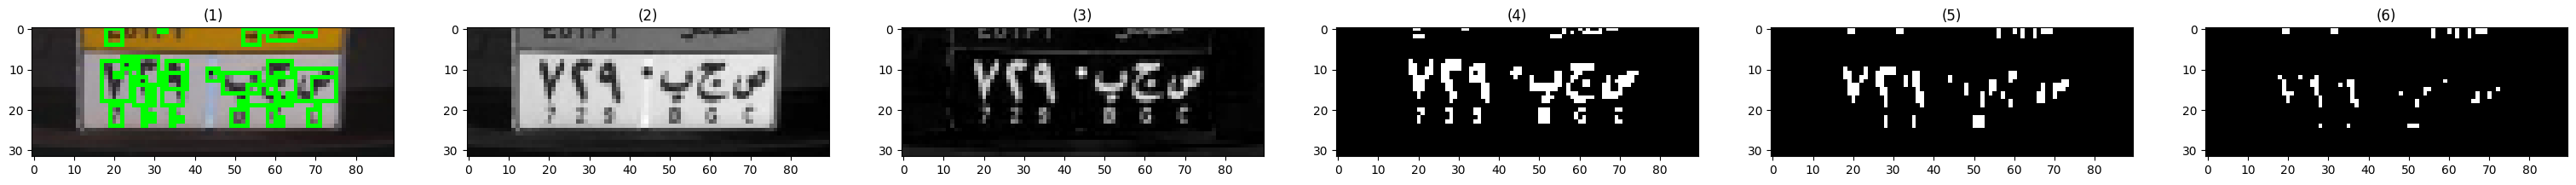

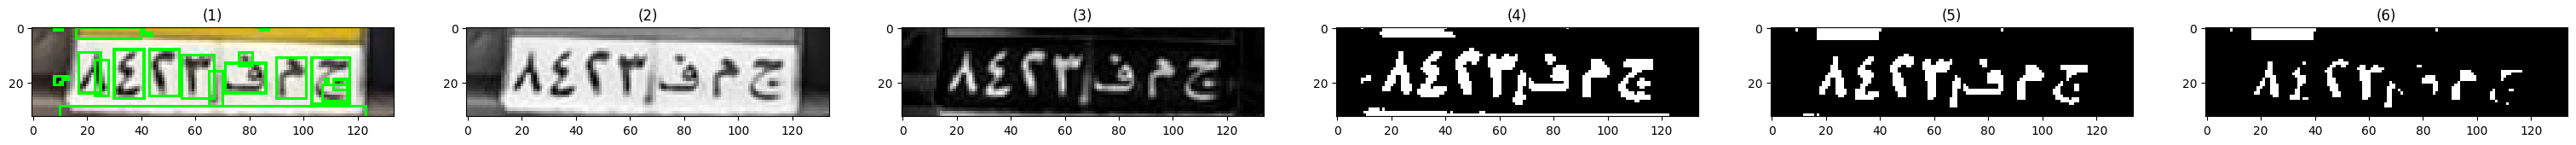

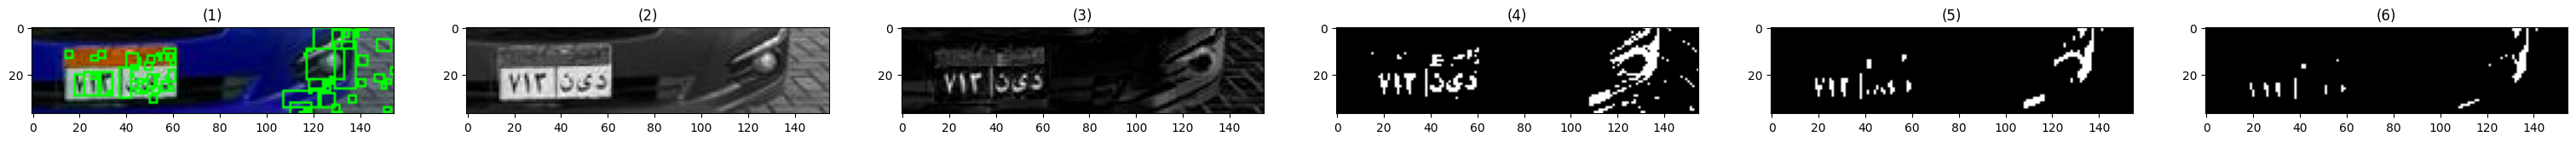

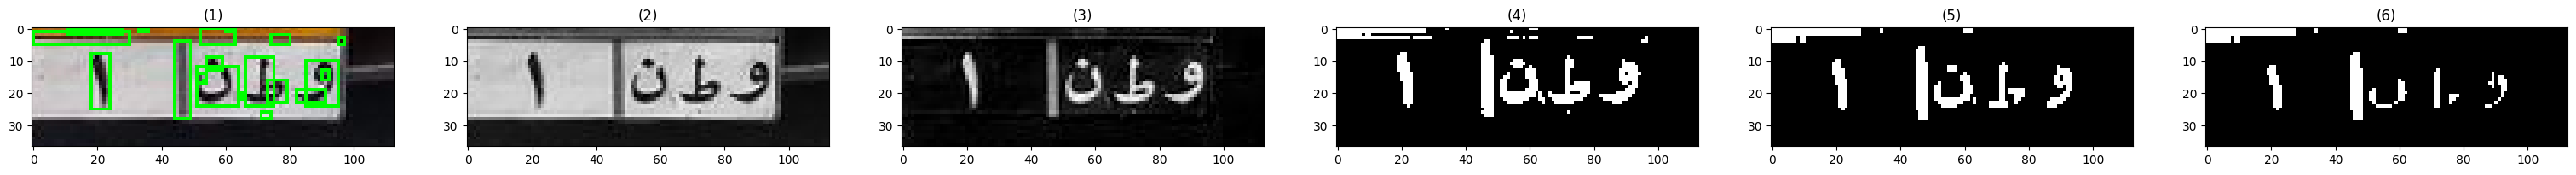

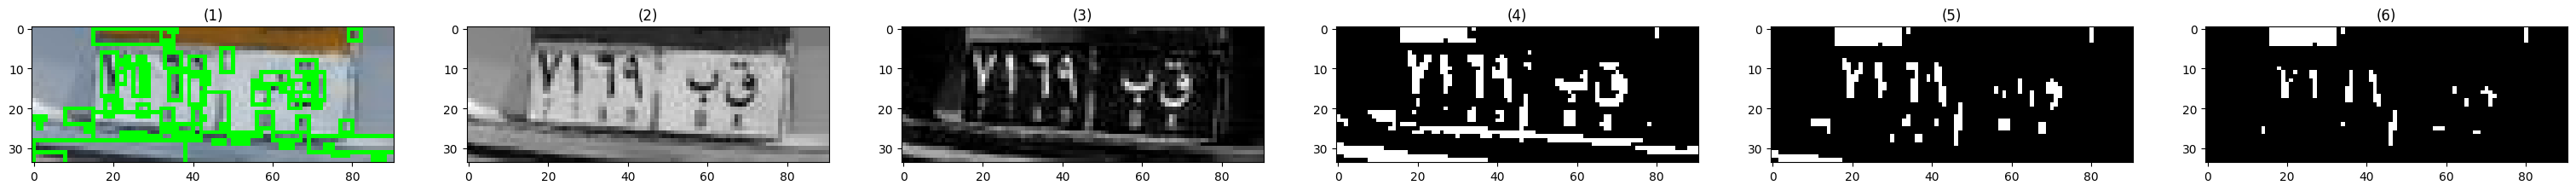

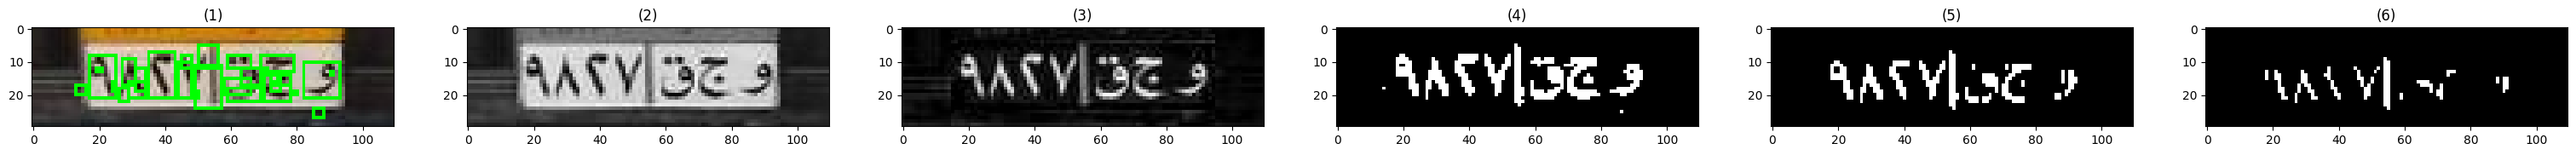

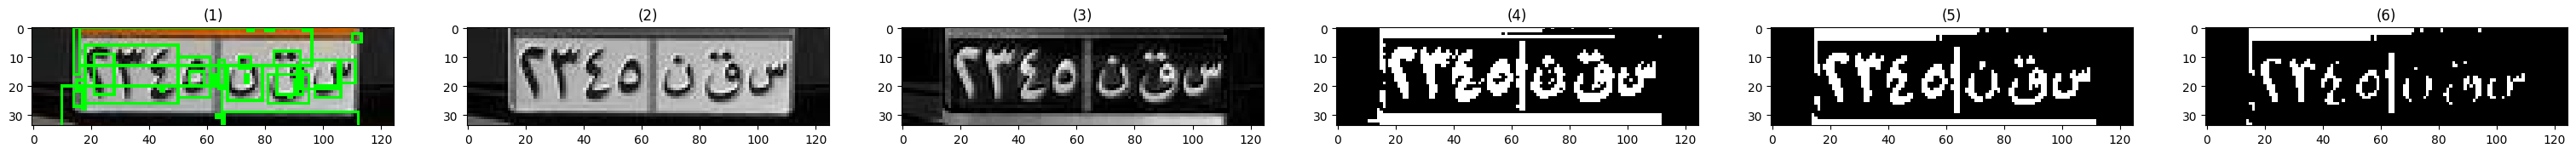

In [236]:
import os
images = os.listdir('images')
for image in images:
    DetectChars(LPD(cv.imread('images/'+image)))
    
# DetectChars(LPD(cv.imread('images/0261.jpg')))